## Track 2: Kernel-Based Reinforcement Learning
### Rithesh Kumar (260848114)


#### Summary of Kernel-based Reinforcement Learning
1. These class of methods store $s' \rightarrow g $ pairs in memory, where $s'$ is the state and $g$ is the update target (ex: value of the state). Whenever a value of query state $s$ is required, the value of the nearest example in memory is retrieved as the value of the query state.

2. More concretely, KBRL uses kernel regression to compute the value of the query state as:
$$ \hat{v}(s, \mathcal{D}) = \sum_{s' \in \mathcal{D}} k(s, s')g(s') $$

3. These update targets $g(s')$ can be **Monte-Carlo returns**, **TD-update target**, or **Expected Returns** $\mathbb{E}[g[s']]$.

4. In this work, i chose to use the **Expected Return** as the update targets (similar to the method proposed in KBRL - Ormoneit and Sen paper). 

#### Computing Expected Returns (Value function) for states in memory:
1. We perform a **finite model approximation** of the continuous MDP, by sampling transitions from the continuous MDP, storing it in a memory, and build a discrete finite MDP solely composed of the states stored in memory.
2. More concretely, we store sample transitions $S^a \equiv \{(s_k^a, r_k^a, \hat{s}_k^a)\ \big\vert \ k = 1,2,...,n_a\}$ associated with each action $a \in A$. We also use the kernel function $k_\tau(s, s')$ as the gaussian kernel, where $\tau$ is the bandwidth parameter.
$$ k_\tau(s, s') = \exp\bigg( \frac{||s-s'||^2}{\tau} \bigg) $$
We thereby also define the normalized kernel function as:
$$ k_\tau^a(s, s_i^a) = \frac{k_\tau^a(s, s_i^a)}{\sum_j k_\tau(s, s_j^a)} $$
3. Now, the approximate finite MDP can be fully specified as:
$$\begin{eqnarray}
\hat{P}^a\big(\hat{s}_i^b\ \big|\ s\big) &= \begin{cases}
k_\tau^a(s, s_i^b), \text{if } a = b\\
0, otherwise
\end{cases}\\
\hat{R}^a\big(\hat{s}_i^b\ \big|\ s\big) &= \begin{cases}
r_i^a, \text{if } a = b\\
0, otherwise
\end{cases}
\end{eqnarray}$$

4. Having defined the MDP, one can compute the optimal value function using **Dynamic Programming methods**. We specifically use **Value Iteration** in this work, to compute $\hat{V}^*$.
5. To compute the value of any state-action pair in the Continuous MDP (query), we can use the formula:
$$\hat{Q}(s, a) = \sum_{i=1}^{n_a} k_\tau^a(s, s_i^a) \bigg[r_i^a + \gamma \hat{V}^*\big(\hat{s}_i^a\big) \bigg] $$

#### Computational Complexity:
* This section is needed in this report since there are significant computational overheads in non-parameteric methods such as **Nearest-Neighbour regression**.
* The biggest computational overhead is induced by the computation of the transition probability matrix $p(s'\ \big|\ s, a)$. The no. of states in the approximate finite mdp is: $\hat{n} = \sum_a n_a$. Therefore, the nearest-neighbour averaging on every pair of states induces a computational complexity of $\mathcal{O} (\hat{n}^2)$


#### Evaluation Metric:
* In this work, we plot the **total reward per episode**, and also print the total reward for a **baseline random policy**.

In [13]:
!pip install gym
!pip install tqdm
!pip install imageio

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
import gym
import numpy as np
from copy import copy
from tqdm import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(-1, keepdims=True)


def rbf(x, S, sum_axis=-1, bandwidth=1.):
    dists = -np.sum((x - S)**2, axis=sum_axis) / bandwidth
    return softmax(dists)

In [2]:
class KBRL(object):
    def __init__(self, args):
        self.n_actions = args['n_actions']
        self.n_mem = args['n_mem']
        self.state_dim = args['state_dim']
        self.bandwidth = args['bandwidth']
        self.gamma = args['gamma']
        
        self.s_mem = np.zeros((self.n_actions, self.n_mem, self.state_dim))
        self.s_prime_mem = np.zeros((self.n_actions, self.n_mem, self.state_dim))
        self.r_mem = np.zeros((self.n_actions, self.n_mem))
        self.nt_mem = np.zeros((self.n_actions, self.n_mem)) # nt -> Not Terminal State mask
        self.counts = np.zeros(self.n_actions).astype('int')

    def reset(self):
        self.nt_mem = np.ones((self.n_actions, self.n_mem))
        self.counts = np.zeros(self.n_actions).astype('int')

    def compute_mdp(self):
        n_states_new = self.n_mem * self.n_actions
        P_est = np.zeros(
            (self.n_actions, n_states_new, n_states_new)  # (a, s, s')
        ).astype('float32')

        R_est = np.zeros(
            (self.n_actions, n_states_new, n_states_new)  # (a, s, s')
        ).astype('float32')

        nt = self.nt_mem.reshape((-1))
        s_prime = self.s_prime_mem.reshape((-1, self.state_dim, 1))

        for i in xrange(self.n_actions):
            start_idx = i * self.n_mem
            end_idx = (i + 1) * self.n_mem

            probs = rbf(
                s_prime,
                self.s_mem[i].T[None],
                sum_axis=1,
                bandwidth=self.bandwidth
            )

            P_est[i, :, start_idx:end_idx] = probs
            R_est[i, :, start_idx:end_idx] = self.r_mem[i]

        R_est = (P_est * R_est).sum(-1) # Expected Reward
        self.MDP = (P_est, R_est, nt)

    def value_iteration(self):
        P, R, N = self.MDP
        V = np.zeros(self.n_mem * self.n_actions).astype('float32')
        count = 0
        while True:
            count += 1

            val_s_prime = (N * V)[None, None, :]
            Q = R + self.gamma * (P * val_s_prime).sum(-1)
            new_V = Q.max(0)

            delta = np.abs(new_V - V).max()
            if count % 10 == 0:
                print "{}.) Delta: {}".format(count, delta)
            if delta < 0.01:
                break
            else:
                V = new_V
        print "Converged at {} iters!".format(count)
        self.V = new_V

    def get_action(self, s):
        P, _, N = self.MDP
        V = self.V
        R = self.r_mem

        q_vals = np.zeros(self.n_actions)
        for i in xrange(self.n_actions):
            start_idx = i * self.n_mem
            end_idx = (i + 1) * self.n_mem

            probs = rbf(s[None], self.s_mem[i], bandwidth=self.bandwidth)

            Q = R[i] + (self.gamma * N * V)[start_idx: end_idx]
            q_vals[i] = (probs * Q).sum()

        return q_vals.argmax()
        
    def store_mem(self, s, a, r, s_prime, term):
        self.s_mem[a, self.counts[a]] = s
        self.s_prime_mem[a, self.counts[a]] = s_prime
        self.r_mem[a, self.counts[a]] = r
        self.nt_mem[a, self.counts[a]] = term
        self.counts[a] = (self.counts[a] + 1) % self.n_mem


In [41]:
def sample_transitions(env, args, model):
    rewards = []
    avg_reward = 0

    s = env.reset()
    for i in xrange(args['n_steps']):
        a = np.random.choice(args['n_actions'])

        s_prime, r, term, _ = env.step(a)
        avg_reward += r
        
        model.store_mem(s, a, r, s_prime, int(term == False))

        if term:
            s = env.reset()
            rewards.append(avg_reward)
            avg_reward = 0
        else:
            s = copy(s_prime)

    return np.mean(rewards)


def play_game(env, args, model):
    rewards = []
    avg_reward = 0
    n_episodes = 0

    s = env.reset()
    while n_episodes < 100:
        a = model.get_action(s)
        s, r, term, _ = env.step(a)

        avg_reward += r
        
        if term:
            s = env.reset()
            rewards.append(avg_reward)
            avg_reward = 0
            n_episodes += 1
            
            if n_episodes % 25 == 0:
                print "{}% completed!".format(n_episodes)

    return rewards, np.mean(rewards)


def save_game_gif(name, fps, env, args, model, max_steps=1000):
    frames = []
    s = env.reset()
    frames.append(env.render(mode='rgb_array'))
    for i in xrange(max_steps):
        a = model.get_action(s)
        s, r, term, _ = env.step(a)
        frames.append(env.render(mode='rgb_array'))
        if term:
            s = env.reset()
    imageio.mimsave(name+'.gif', frames, fps=50)

In [4]:
np.random.seed(111)
env = gym.make('CartPole-v1')
env.seed(111)

args = {
    'n_actions': env.action_space.n,
    'n_mem': 6000,
    'gamma' : 0.95,
    'bandwidth' : .01,
    'state_dim': env.observation_space.shape[0]
}
args['n_steps'] = int(args['n_mem'] * args['n_actions'] * 2)

print "Environment: CartPole-v0"
print "No. of actions = ", args['n_actions']
print "State space = ", args['state_dim']

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Environment: CartPole-v0
No. of actions =  2
State space =  4


In [5]:
model = KBRL(args)
avg_reward = sample_transitions(env, args, model)
print "Baseline average reward: ", avg_reward
print "Approximating MDP!"
model.compute_mdp()
print "Starting Value Iteration..."
model.value_iteration()

Baseline average reward:  22.3634669152
Approximating MDP!
Starting Value Iteration...
10.) Delta: 0.630249598054
20.) Delta: 0.377353807247
30.) Delta: 0.22593572749
40.) Delta: 0.135276104046
50.) Delta: 0.0809948232134
60.) Delta: 0.0484946061083
70.) Delta: 0.029035520121
80.) Delta: 0.0173846432718
90.) Delta: 0.0104088309805
Converged at 91 iters!


Playing 100 games to test model!
25% completed!
50% completed!
75% completed!
100% completed!
Average reward using KBRL:  416.16
Plotting reward...


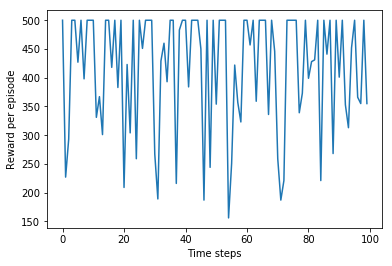

In [7]:
print "Playing 100 games to test model!"
tot_reward, avg_reward = play_game(env, args, model)
print "Average reward using KBRL: ", avg_reward
print "Plotting reward..."
plt.plot(tot_reward)
plt.xlabel("Time steps")
_ = plt.ylabel("Reward per episode")

In [35]:
save_game_gif('cartpole', env, args, model)

# Sample Gameplay
![cartpole](cartpole.gif "cartpole")

In [36]:
np.random.seed(111)
env = gym.make('Acrobot-v1')
env.seed(111)

args = {
    'n_actions': env.action_space.n,
    'n_mem': 5000,
    'gamma' : 0.95,
    'bandwidth' : .4,
    'state_dim': env.observation_space.shape[0]
}
args['n_steps'] = int(args['n_mem'] * args['n_actions'] * 1.2)

print "Environment: Acrobot-v1"
print "No. of actions = ", args['n_actions']
print "State space = ", args['state_dim']

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Environment: Acrobot-v1
No. of actions =  3
State space =  6


Baseline average reward:  -500.0
Approximating MDP!
Starting Value Iteration...
10.) Delta: 0.622275704558
20.) Delta: 0.363988884834
30.) Delta: 0.21282416735
40.) Delta: 0.124428575023
50.) Delta: 0.0727448002432
60.) Delta: 0.0425282605602
70.) Delta: 0.0248627594782
80.) Delta: 0.0145351620382
Converged at 87 iters!
Playing 100 games to test model!
25% completed!
50% completed!
75% completed!
100% completed!
Average reward using KBRL:  -171.05
Plotting reward...


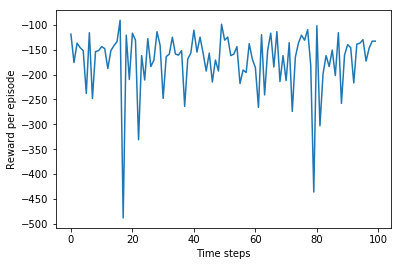

In [37]:
model = KBRL(args)
avg_reward = sample_transitions(env, args, model)
print "Baseline average reward: ", avg_reward
print "Approximating MDP!"
model.compute_mdp()
print "Starting Value Iteration..."
model.value_iteration()

print "Playing 100 games to test model!"
tot_reward, avg_reward = play_game(env, args, model)
print "Average reward using KBRL: ", avg_reward
print "Plotting reward..."
plt.plot(tot_reward)
plt.xlabel("Time steps")
_ = plt.ylabel("Reward per episode")

In [42]:
save_game_gif('acrobot', 15, env, args, model)

# Sample Gameplay
![acrobot](acrobot.gif "acrobot")